In [1]:
!git clone https://github.com/pdhruv93/YOLO-Object-Detection.git

Cloning into 'YOLO-Object-Detection'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Receiving objects: 100% (30/30), 12.60 MiB | 32.50 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
%cd YOLO-Object-Detection//yolo-object-detection

/content/YOLO-Object-Detection/yolo-object-detection


In [3]:
!wget "https://pandawhocodes.s3.amazonaws.com/yolov3.weights"

--2023-10-30 16:36:31--  https://pandawhocodes.s3.amazonaws.com/yolov3.weights
Resolving pandawhocodes.s3.amazonaws.com (pandawhocodes.s3.amazonaws.com)... 3.5.25.134, 3.5.25.179, 16.182.103.177, ...
Connecting to pandawhocodes.s3.amazonaws.com (pandawhocodes.s3.amazonaws.com)|3.5.25.134|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-10-30 16:36:31 ERROR 404: Not Found.



In [4]:
from imutils.video import VideoStream
from imutils.video import FPS
import time
import numpy as np
import cv2
import imutils

In [5]:
yoloPath="yolo-coco"
#yolo --base path to YOLO directory
#confidence --minimum probability to filter weak detections
#threshold --threshold when applyong non-maxima suppression
args={'yolo': yoloPath , 'confidence': 0.5, 'threshold': 0.3}

In [6]:
# load the COCO class labels our YOLO model was trained on
LABELS = open(yoloPath+"//coco.names").read().strip().split("\n")
print("Toal classes {0}".format(len(LABELS)))

Toal classes 80


In [9]:
# initialize a list of colors to represent each possible class label
np.random.seed(42)
#create random list of int type numbers from range 0-255. Size = len(LABELS), 3... 3 is for RGB
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [12]:
! wget "https://pjreddie.com/media/files/yolov3.weights"


--2023-10-30 16:38:44--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  46.9MB/s    in 5.5s    

2023-10-30 16:38:50 (42.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [13]:
# derive the paths to the YOLO weights and model configuration
weightsPath = "yolov3.weights"
configPath = yoloPath+"//yolov3.cfg"
# load our YOLO object detector trained on COCO dataset (80 classes)
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

In [14]:
#Generally in a sequential CNN network there will be only one output layer at the end.
#In the YOLO v3 architecture we are using there are multiple output layers giving out predictions.
ln_all = net.getLayerNames()
#print(ln)

ln=[]
# determine only the *output* layer names that we need from YOLO
for i in ln_all:
    if "yolo" in i:
        ln.append(i)

print(ln)

['yolo_82', 'yolo_94', 'yolo_106']


In [15]:
'''
## Camera Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
'''

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // show the video in the HTML element
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // prints the logs to cell
      let jsLog = function(abc) {
        document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
      }

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      for (let i = 0; i < 5; i++) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        img = canvas.toDataURL('image/jpeg', quality);

        // show each captured image
        // let imgTag = document.createElement('img');
        // imgTag.src = img;
        // div.appendChild(imgTag);

        jsLog(i + "sending")
        // Call a python function and send this image
        google.colab.kernel.invokeFunction('notebook.run_algo', [img], {});
        jsLog(i + "SENT")

        // wait for X miliseconds second, before next capture
        await new Promise(resolve => setTimeout(resolve, 250));
      }

      stream.getVideoTracks()[0].stop(); // stop video stream
    }
    ''')
  display(js) # make the provided HTML, part of the cell
  data = eval_js('takePhoto({})'.format(quality)) # call the takePhoto() JavaScript function

<IPython.core.display.Javascript object>

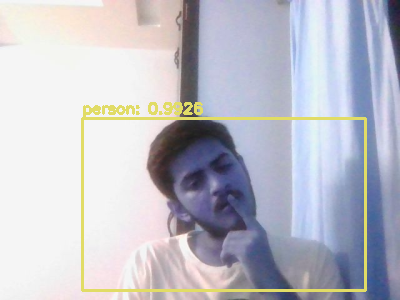

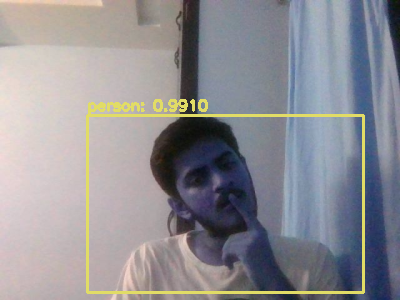

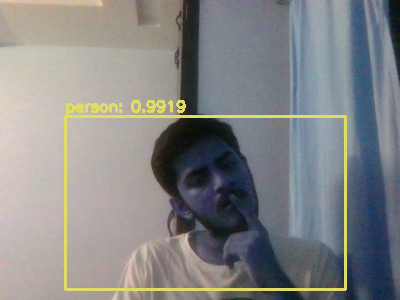

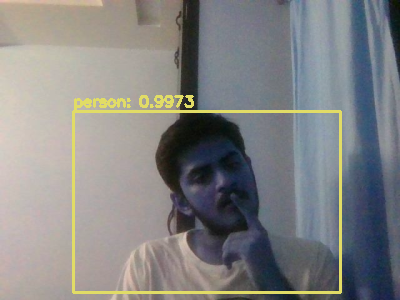

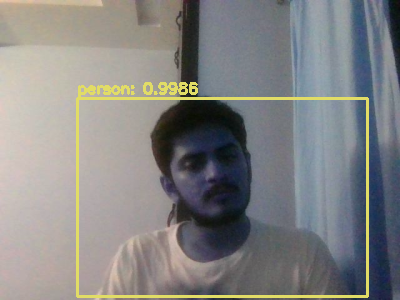

In [16]:
import IPython
from google.colab import output
from google.colab.patches import cv2_imshow

import time
import sys
import numpy as np
import cv2

from PIL import Image
from io import BytesIO
import base64
import logging


def data_uri_to_img(uri):
    """convert base64image to numpy array"""
    try:
        image = base64.b64decode(uri.split(',')[1], validate=True)
        # make the binary image, a PIL image
        image = Image.open(BytesIO(image))
        # convert to numpy array
        image = np.array(image, dtype=np.uint8);
        return image
    except Exception as e:
        logging.exception(e);
        print('\n')
        return None


def run_algo(imgB64):
    """
    in Colab, run_algo function gets invoked by the JavaScript, that sends N images every second

    params:
      image: image
    """
    image = data_uri_to_img(imgB64)
    frame = image
    if image is None:
        print("At run_algo(): image is None.")
        return

    try:
        # Run detection
        frame = imutils.resize(frame, width=400)
        (H, W) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        # perform a forward pass of the YOLO object detector, giving us our bounding boxes and associated probabilities
        layerOutputs = net.forward(ln)

        # yolo has now processed our image and got the data. we now just need to fetch that data
        # initialize empty lists
        boxes = []
        confidences = []
        classIDs = []

        # Let’s begin populating these lists with data from our YOLO layerOutputs
        # loop over each of the layer outputs
        for output in layerOutputs:
            # loop over each of the detections
            for detection in output:
                # extract the class ID and confidence (i.e., probability) of the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                # filter out weak predictions by ensuring the detected probability is greater than the minimum probability
                if confidence > args["confidence"]:
                    # scale the bounding box coordinates back relative to the size of the image
                    # YOLO returns the center (x, y)-coordinates of the bounding box followed by the box width and height
                    box = detection[0:4] * np.array([W, H, W, H])

                    # astype("int") witll convert box values to int values
                    (centerX, centerY, width, height) = box.astype("int")

                    # use the center (x, y)-coordinates to derive the top-left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    # update our list of bounding box coordinates, confidences and class IDs
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)


            # apply non-maxima suppression to suppress weak, overlapping bounding boxes
            # All that is required is that we submit our:
            # bounding boxes , confidences , confidence threshold and NMS threshold
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"], args["threshold"])

        # idxs now hold indexes after non maxima suppression

        # draw the boxes and class text on the frame
        if len(idxs) > 0:
            for i in idxs.flatten():
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])  # x,y--coordinate of top left corner
                (w, h) = (boxes[i][2], boxes[i][3])

                # pick the color
                color = [int(c) for c in COLORS[classIDs[i]]]

                # draw a bounding box rectangle
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)  # 2 is the line thickness

                # prepare text
                text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])

                # put text on image at x, y-5....a bit up then the box
                cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        cv2_imshow(frame)
    except Exception as e:
        logging.exception(e)

# register this function, so JS code could call this
output.register_callback('notebook.run_algo', run_algo)

# put the JS code in cell and run it
take_photo()
